In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils import *
from core import *
import imageio.v3 as iio
from PIL import Image

im = iio.imread('../800px-SheppLogan.png')

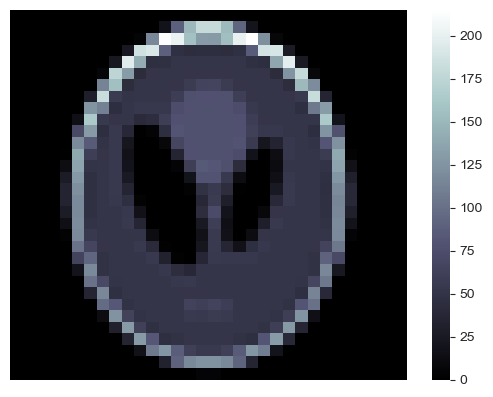

In [2]:
# loading image
new_res = 32

img = Image.fromarray(im).resize((new_res, new_res))
img = np.array(img.convert('L'))
plot_image(img, cmap='bone')

In [3]:
params = {
  "no_of_detectors": 32,
  "source_to_object": 100,
  "source_to_detector": 200,
  "size_of_object": 20,
  "no_of_rotations": 64,
  "detector_aperture": 2,
  "resolution": new_res
}

In [4]:
A = CreateInterceptMatrix(**params).create_intercept_matrix_from_lines()

## Forward Problem

solving the forward problem of obtaining detector readings using image matrix (shepp Logan)

In [5]:
x = img
x.shape

(32, 32)

In [6]:
A.shape

(2048, 1024)

In [7]:
b = A @ x.flatten()
b.shape

(2048,)

## Backward Problem

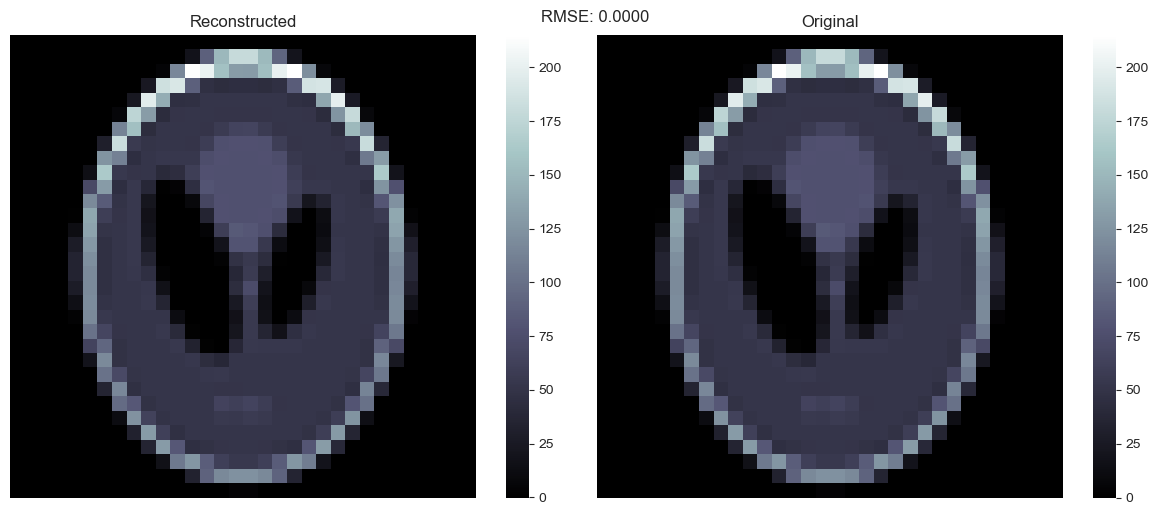

In [9]:
x = SolveEquation(A, b).solve(useLibrary='lstsq')
plot_images(x.reshape(new_res, -1), img, cmap='bone')